# Forecasting Sunspot Data using Pytorch

Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # this will set the device if a GPU is available

Loading the data:

In [3]:
df_sunspots = pd.read_csv("/kaggle/input/sunspots/Sunspots.csv")
print(df_sunspots.shape)
print(df_sunspots.head())

(3265, 3)
   Unnamed: 0        Date  Monthly Mean Total Sunspot Number
0           0  1749-01-31                               96.7
1           1  1749-02-28                              104.3
2           2  1749-03-31                              116.7
3           3  1749-04-30                               92.8
4           4  1749-05-31                              141.7


Split the data into training, validation, and testing sets.

Number of months in training set: 2285
Number of months in validation set: 489
Number of months in testing set: 491


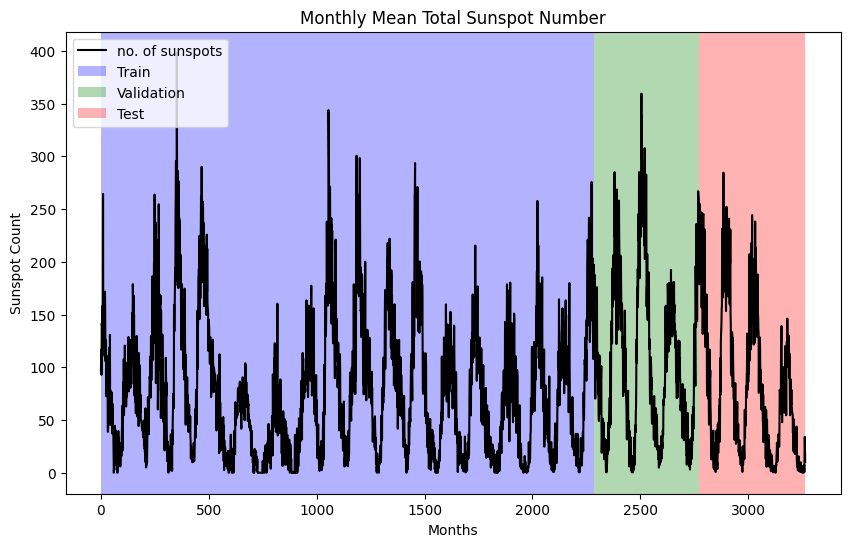

In [4]:
# 70% training, 15% validation, 15% testing
total_rows = len(df_sunspots)
train_size = int(total_rows * 0.7)
val_size = int(total_rows * 0.15)

train_data = df_sunspots.iloc[:train_size]
val_data = df_sunspots.iloc[train_size:train_size+val_size]
test_data = df_sunspots.iloc[train_size+val_size:]

print("Number of months in training set:", len(train_data))
print("Number of months in validation set:", len(val_data))
print("Number of months in testing set:", len(test_data))

plt.figure(figsize=(10, 6))
plt.plot(df_sunspots['Monthly Mean Total Sunspot Number'], color='black', label='')
plt.title('Monthly Mean Total Sunspot Number')
plt.xlabel('Months')
plt.ylabel('Sunspot Count')
plt.axvspan(0, train_size, facecolor='blue', alpha=0.3)
plt.axvspan(train_size,train_size + val_size, facecolor='green', alpha=0.3)
plt.axvspan(train_size+val_size, len(df_sunspots), facecolor='red', alpha=0.3)
plt.legend(['no. of sunspots','Train', 'Validation', 'Test'], loc='upper left')
plt.show()

## Baseline 1

We can set the first baseline model by using the previous month's data to predict the next month's data in validation and testing:

Baseline 1 validation MSE: 751.6406352459016
Baseline 1 testing MSE: 634.1283877551019


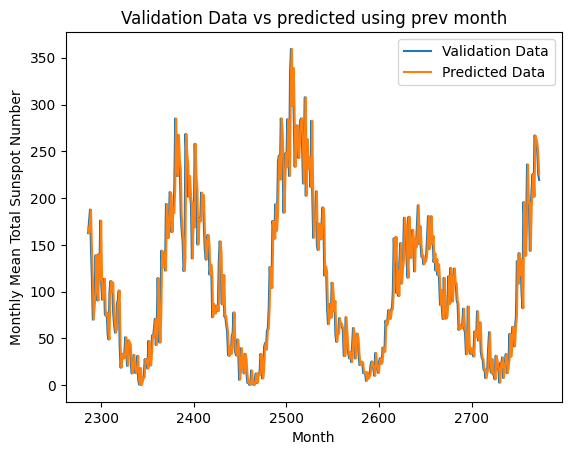

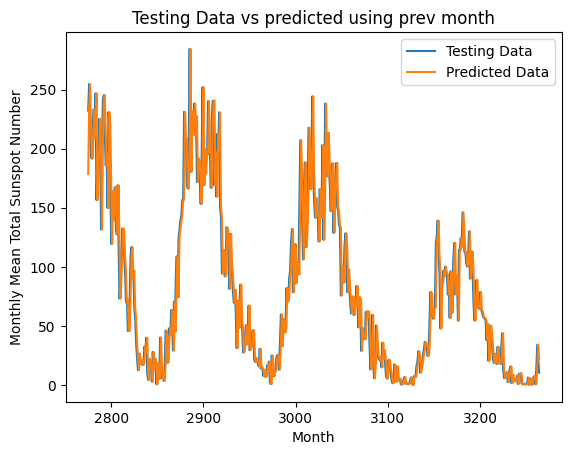

In [5]:
val_predicted_prev_month = val_data.shift(1)['Monthly Mean Total Sunspot Number'].values
test_predicted_prev_month = test_data.shift(1)['Monthly Mean Total Sunspot Number'].values
val_predicted_prev_month = val_predicted_prev_month[1:] #removing the first month
test_predicted_prev_month = test_predicted_prev_month[1:] #removing the first month

val_predicted_prev_month = val_data.shift(1)['Monthly Mean Total Sunspot Number'].values[1:] #first month cannot be predicted so remove it
test_predicted_prev_month = test_data.shift(1)['Monthly Mean Total Sunspot Number'].values[1:]

#computing MSE:
val_mse_prev_month = np.mean((val_predicted_prev_month - val_data['Monthly Mean Total Sunspot Number'].values[1:])**2)
test_mse_prev_month = np.mean((test_predicted_prev_month - test_data['Monthly Mean Total Sunspot Number'].values[1:])**2)

print("Baseline 1 validation MSE:", val_mse_prev_month)
print("Baseline 1 testing MSE:", test_mse_prev_month)

plt.plot(val_data.index[1:], val_data['Monthly Mean Total Sunspot Number'].values[1:], label='Validation Data')
plt.plot(val_data.index[1:], val_predicted_prev_month, label='Predicted Data')
plt.xlabel('Month')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.title('Validation Data vs predicted using prev month')
plt.legend()
plt.show()

plt.plot(test_data.index[1:], test_data['Monthly Mean Total Sunspot Number'].values[1:], label='Testing Data')
plt.plot(test_data.index[1:], test_predicted_prev_month, label='Predicted Data')
plt.xlabel('Month')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.title('Testing Data vs predicted using prev month')
plt.legend()
plt.show()


## Baseline 2

We can set the second baseline by using self-correlation to find the cyclical pattern in the data

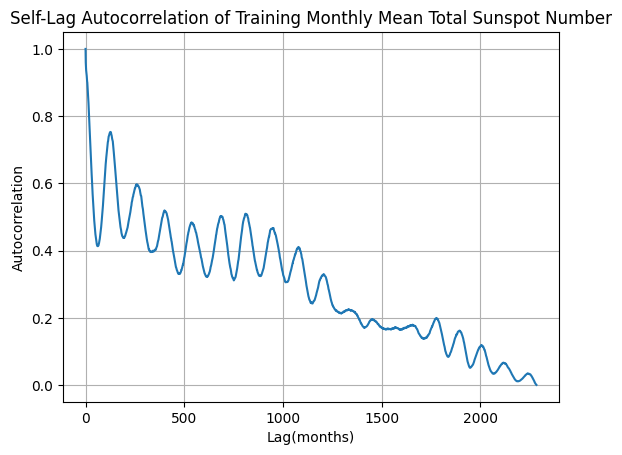

In [6]:
sunspot_data = train_data['Monthly Mean Total Sunspot Number'].values
autocorr = np.correlate(sunspot_data, sunspot_data, mode='full')
autocorr /= np.max(np.abs(autocorr))

autocorr = autocorr[len(autocorr)//2:] #autocorrelation computes negative and positive values, we only need positive values
plt.plot(autocorr)
plt.title('Self-Lag Autocorrelation of Training Monthly Mean Total Sunspot Number')
plt.xlabel('Lag(months)')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

We do see some periodicity. The top value is obviously autocorrelation at 0 lag. But what about the others?

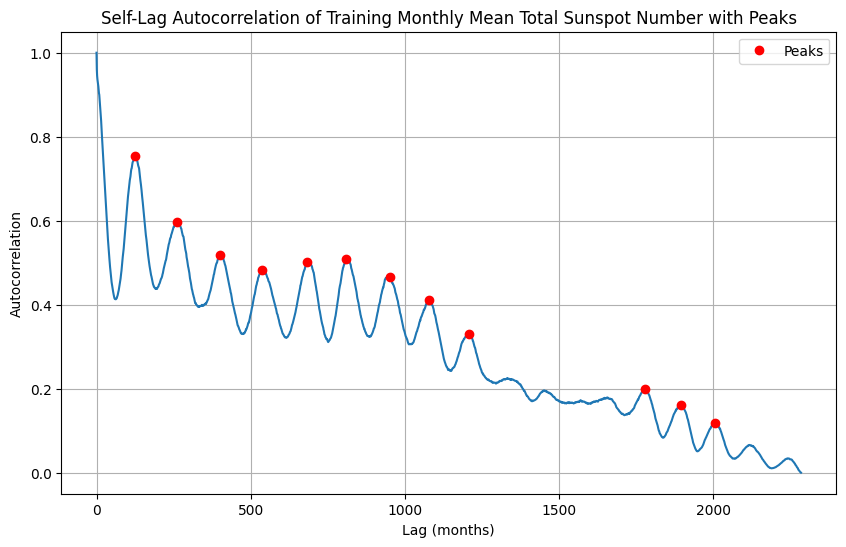

Lag values (months) corresponding to peaks: [ 126  260  400  537  684  810  952 1078 1206 1777 1894 2006]
Lag values (years) corresponding to peaks: [ 10.  22.  33.  45.  57.  68.  79.  90. 100. 148. 158. 167.]


In [7]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(autocorr, distance=12, prominence=0.05)
# Plot autocorrelation with peaks
plt.figure(figsize=(10, 6))
plt.plot(autocorr)  
plt.plot(peaks, autocorr[peaks], 'ro', label='Peaks')
plt.title('Self-Lag Autocorrelation of Training Monthly Mean Total Sunspot Number with Peaks')
plt.xlabel('Lag (months)')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True)
plt.show()
print("Lag values (months) corresponding to peaks:", peaks)
print("Lag values (years) corresponding to peaks:", np.round(peaks/12))

Not surprisingly, the autocorrelation is maximum at ~11 years periods, which is known to be the sunspot solar cycle. Well set up our optimum lag at 126 months, as it is the most prominent peak in the autocorrelation plot.

In [8]:
best_lag = peaks[0]
print("Best lag determined by Autocorr analysis:", best_lag, "months")

Best lag determined by Autocorr analysis: 126 months


As the best lag is 126 months, we will divide all the data into repetitions of 126 months. Then, for each i-th month well compute the average of the i-th month in all the repetitions in the training batch. This will be our prediction for the i-th month in the validation and testing sets.

In [9]:
# Calculate the number of repetitions
num_repetitions = np.ceil(len(df_sunspots) / best_lag).astype(int)
idxMonths = np.tile(np.arange(best_lag), num_repetitions)
idxMonths = idxMonths[:len(df_sunspots)]
train_idxMonts = idxMonths[:train_size]
val_idxMonts = idxMonths[train_size:train_size+val_size]
test_idxMonts = idxMonths[train_size+val_size:]

We can then compute the average for each month in the training set and use that as the prediction for the validation and testing sets:

Text(0, 0.5, 'Average Sunspot Number')

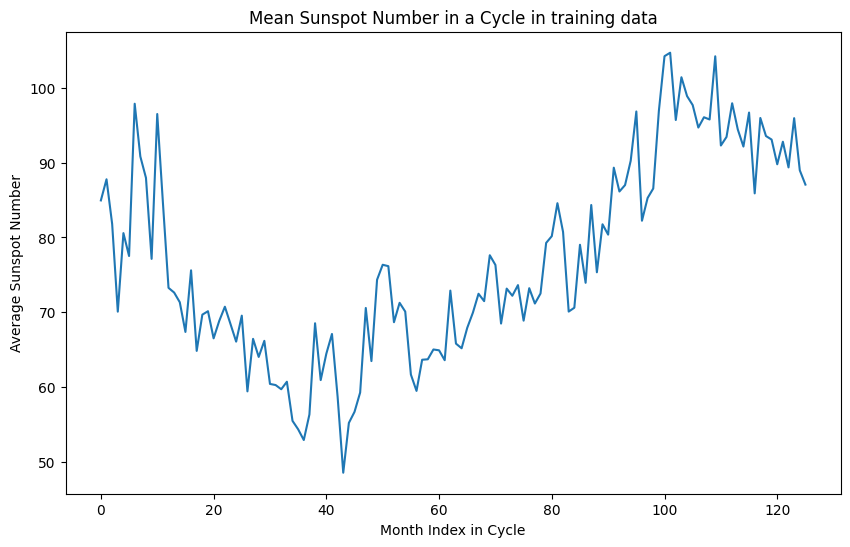

In [10]:
mean_cycle = [np.mean(train_data['Monthly Mean Total Sunspot Number'].values[train_idxMonts == i]) for i in range(best_lag)]
plt.figure(figsize=(10, 6))
plt.plot(mean_cycle)
plt.title('Mean Sunspot Number in a Cycle in training data')
plt.xlabel('Month Index in Cycle')
plt.ylabel('Average Sunspot Number')

Then we can compare the sunspots for validation and testing using the average of the cycles from training:

Baseline 2 validation MSE: 5998.189019774949
Baseline 2 testing MSE: 5047.0110273262135


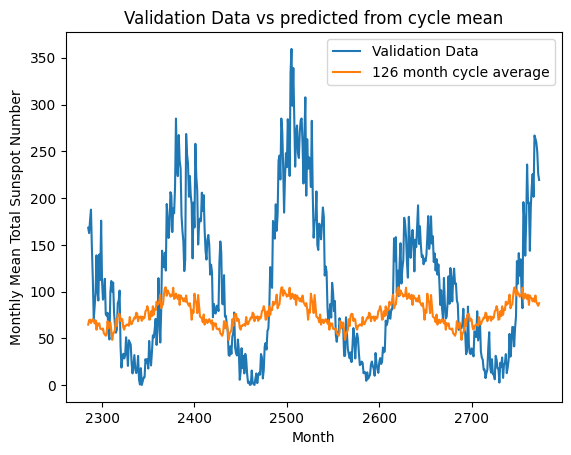

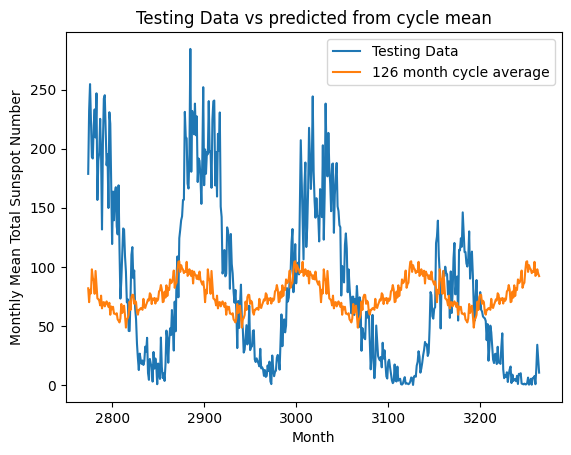

In [11]:
val_predicted_mean_cycle = [mean_cycle[i] for i in val_idxMonts]
test_predicted_mean_cycle = [mean_cycle[i] for i in test_idxMonts]

#computing MSE:
val_mse_mean_cycle = np.mean((val_predicted_mean_cycle - val_data['Monthly Mean Total Sunspot Number'].values)**2)
test_mse_mean_cycle = np.mean((test_predicted_mean_cycle - test_data['Monthly Mean Total Sunspot Number'].values)**2)

print("Baseline 2 validation MSE:", val_mse_mean_cycle)
print("Baseline 2 testing MSE:", test_mse_mean_cycle)

plt.plot(val_data.index, val_data['Monthly Mean Total Sunspot Number'], label='Validation Data')
plt.plot(val_data.index, val_predicted_mean_cycle, label='126 month cycle average')
plt.xlabel('Month')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.title('Validation Data vs predicted from cycle mean')
plt.legend()
plt.show()

plt.plot(test_data.index, test_data['Monthly Mean Total Sunspot Number'].values, label='Testing Data')
plt.plot(test_data.index, test_predicted_mean_cycle, label='126 month cycle average')
plt.xlabel('Month')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.title('Testing Data vs predicted from cycle mean')
plt.legend()

It seems like the repeating pattern aligns with the oscillatory behavior also in the train and test sets. Although the scale is not correct, as we can observe that the cycle occurs with different amplitudes in the train set

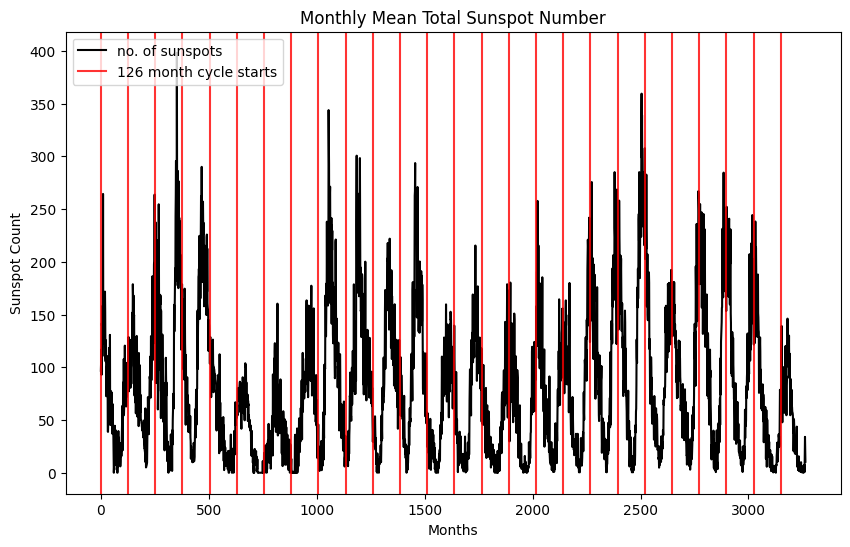

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(df_sunspots['Monthly Mean Total Sunspot Number'], color='black', label='')
plt.title('Monthly Mean Total Sunspot Number')
plt.xlabel('Months')
plt.ylabel('Sunspot Count')
for i in range(0, len(df_sunspots), best_lag):
    plt.axvline(i, color='red', alpha=0.8)

plt.legend(['no. of sunspots','126 month cycle starts'], loc='upper left')
plt.show()

We can see that although the sunspot cycles on a 126 month period, the amplitude of the cycles and the start/stop of the cycles is not constant. This is why the prediction is not that accurate.

## Baseline 3


Another option to check periodicity is to use Fourier Transform, we can use the FFT to find the optimum period of the sunspot cycle. And see if the result is better than using the autocorrelation.

Additionally, we can use the median of the sunspots in the training set to predict the sunspots in the validation and testing sets, instead of the mean, as that can reduce the effect of the outliers (cycles with much lower amplitudes)

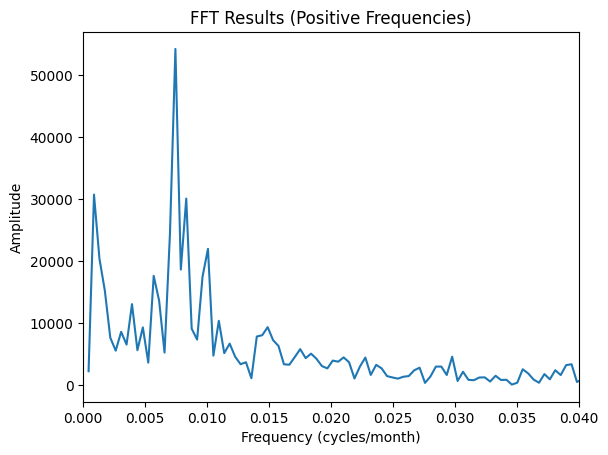

Best lag determined by Fourier analysis: 134.41176470588235 months


In [13]:
from scipy.fft import fft

# Calculate FFT
fft_result = fft(train_data['Monthly Mean Total Sunspot Number'].values)

# Calculate the frequencies
n = len(train_data)
sampling_frequency = 1  # samples per month
freq = np.fft.fftfreq(n, d=1/sampling_frequency)  # d is the spacing between samples
positive_freq_mask = freq > 0  # select positive frequencies

# Plot positive frequency components
plt.plot(freq[positive_freq_mask], np.abs(fft_result[positive_freq_mask]))
plt.xlim(0, 0.04)
plt.xlabel('Frequency (cycles/month)')
plt.ylabel('Amplitude')
plt.title('FFT Results (Positive Frequencies)')
plt.show()
# Find the index of the maximum positive frequency
max_freq_index = np.argmax(np.abs(fft_result[positive_freq_mask]))

# Calculate the period corresponding to the maximum positive frequency
period = 1 / freq[positive_freq_mask][max_freq_index]

print("Best lag determined by Fourier analysis:", period, "months")
best_lag = int(round(period))

Text(0, 0.5, 'Median Sunspot Number')

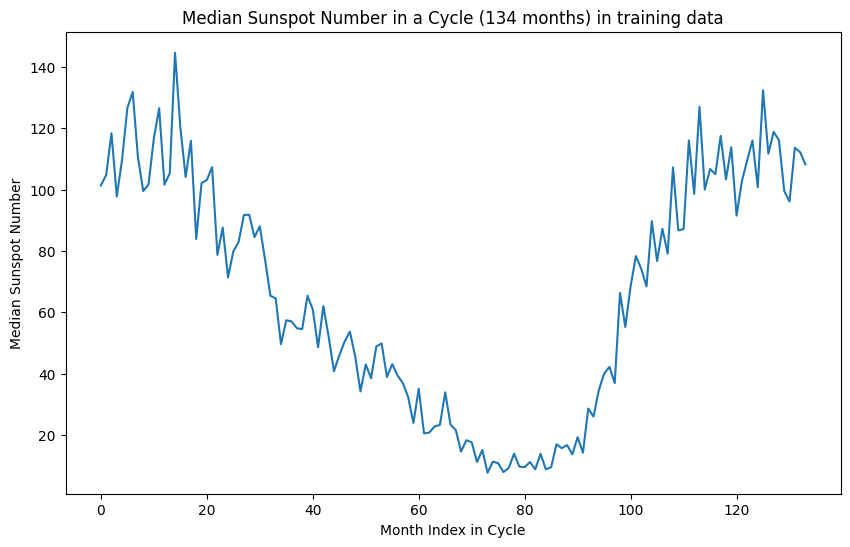

In [14]:
num_repetitions = np.ceil(len(df_sunspots) / best_lag).astype(int)
idxMonths = np.tile(np.arange(best_lag), num_repetitions)
idxMonths = idxMonths[:len(df_sunspots)]
train_idxMonts = idxMonths[:train_size]
val_idxMonts = idxMonths[train_size:train_size+val_size]
test_idxMonts = idxMonths[train_size+val_size:]

median_cycle = [np.median(train_data['Monthly Mean Total Sunspot Number'].values[train_idxMonts == i]) for i in range(best_lag)] # !! note using median instead of mean
plt.figure(figsize=(10, 6))
plt.plot(median_cycle)
plt.title('Median Sunspot Number in a Cycle (134 months) in training data')
plt.xlabel('Month Index in Cycle')
plt.ylabel('Median Sunspot Number')


Baseline 2 validation MSE: 8909.308399795502
Baseline 2 testing MSE: 8726.34384928717


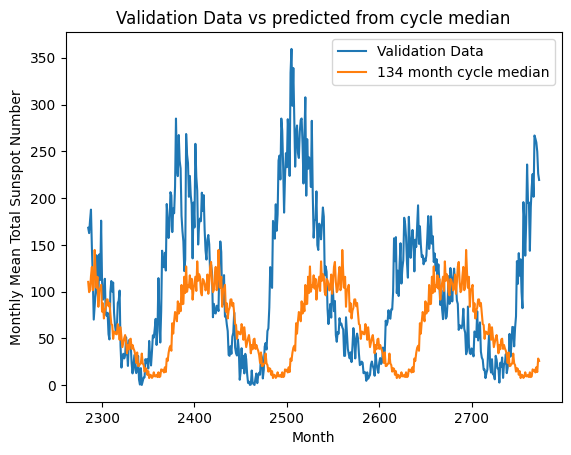

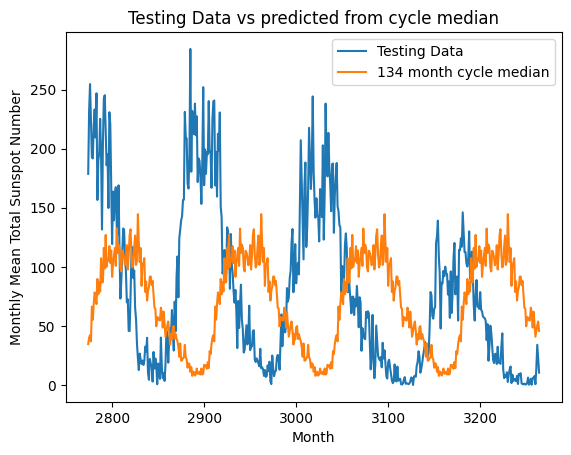

In [15]:
val_predicted_median_cycle = [median_cycle[i] for i in val_idxMonts]
test_predicted_median_cycle = [median_cycle[i] for i in test_idxMonts]

#computing MSE:
val_mse_median_cycle = np.mean((val_predicted_median_cycle - val_data['Monthly Mean Total Sunspot Number'].values)**2)
test_mse_median_cycle = np.mean((test_predicted_median_cycle - test_data['Monthly Mean Total Sunspot Number'].values)**2)

print("Baseline 2 validation MSE:", val_mse_median_cycle)
print("Baseline 2 testing MSE:", test_mse_median_cycle)

plt.plot(val_data.index, val_data['Monthly Mean Total Sunspot Number'], label='Validation Data')
plt.plot(val_data.index, val_predicted_median_cycle, label='134 month cycle median')
plt.xlabel('Month')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.title('Validation Data vs predicted from cycle median')
plt.legend()
plt.show()

plt.plot(test_data.index, test_data['Monthly Mean Total Sunspot Number'].values, label='Testing Data')
plt.plot(test_data.index, test_predicted_median_cycle, label='134 month cycle median')
plt.xlabel('Month')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.title('Testing Data vs predicted from cycle median')
plt.legend()

The cycle is off now, the FFT analysis suggested a periocity of 134.4 months. Because we rounded down to 134, this difference accumulates towards the end of the time-series (the testing and validation sets). This is why the cycle is off.

Either way, we have now three baselines to beat, with the best one being predicting the sunspots of the next month using the sunspots of the previous month. This is obviously not realistic, as the signal is slow-moving, and we might want to have more information than just knowing the next month's sunspots. But it is a good starting point to beat.

## LETS START PLAYING WITH DEEP LEARNING

We first have to prepare the data appropriately, we have to decide on the number of part months (time-steps) we want to use as input features to predict next month's sunspot numbers.


We can utilize Pytorch's Dataset and Dataloader utilities to prepare the data:

We know that the signal is periodic ~ every 126-135 months, we should establish a sequence length that at least captures that. For example, 140

In [16]:
from torch.utils.data import DataLoader, TensorDataset
seq_length = 140

def create_sequences(df, seq_length):
    xs, ys = [], []
    # Iterate over data indices
    for i in range(len(df) - seq_length):
      	# Define inputs
        x = df.iloc[i:(i+seq_length), 2]
        # Define target
        y = df.iloc[i+seq_length, 2]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Use create_sequences to create inputs and targets
X_train, y_train = create_sequences(train_data, 140)
print(X_train.shape, y_train.shape)
X_val, y_val = create_sequences(val_data, 140)
X_test, y_test = create_sequences(test_data, 140)
X_all,y_all = create_sequences(df_sunspots, 140) # will use this to plot the results

# Create TensorDataset
dataset_train = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train).float(),
)

dataset_val = TensorDataset(
    torch.from_numpy(X_val).float(),
    torch.from_numpy(y_val).float(),
)

dataset_test = TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(y_test).float(),
)
dataset_all = TensorDataset(
    torch.from_numpy(X_all).float(),
    torch.from_numpy(y_all).float(),
)

print(len(dataset_train))
print(len(dataset_val))
print(len(dataset_test))
print(len(dataset_all))

(2145, 140) (2145,)
2145
349
351
3125


We can then define the dataloader objects:

In [17]:

batch_size = 32
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size)
test_loader = DataLoader(dataset_test, batch_size=batch_size)
all_loader = DataLoader(dataset_all, batch_size=batch_size)

for inputs, targets in train_loader:
    print("Input batch shape:", inputs.shape)
    print("Target batch shape:", targets.shape)
    break  # Stop after the first batch for demonstration

Input batch shape: torch.Size([32, 140])
Target batch shape: torch.Size([32])


And the training loop:

In [18]:
def train(model, train_loader, val_loader,lossfunction , optimizer, num_epochs=100, best_model_path = 'best_model.pth' ):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf') # initialize to check for best validation loss
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = lossfunction(outputs.squeeze(), targets.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs.float())
                loss = lossfunction(outputs.squeeze(), targets.float())
                val_loss += loss.item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Train MSE: {train_loss:.4f}, Val MSE: {val_loss:.4f}")
            
        # Check if current validation loss is better than the best validation loss, if it is, save the model so it can be loaded later
        if val_loss < best_val_loss:
            # Save the model
            torch.save(model.state_dict(), best_model_path)
            best_val_loss = val_loss        
        
    return train_losses, val_losses

It can be useful to visualize our predictions vs the original data, this will do that:

In [19]:
def generateSequence(model, loader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, target in loader:
            inputs = inputs.to(device)
            outputs = model(inputs.float())
            predictions.extend(outputs.cpu().numpy().squeeze())  # Append predictions to the list
            targets.extend(target.cpu().numpy())  # Append targets to the list
    return predictions, targets

We also want to get the MSE metric for our different models:

In [20]:
import torchmetrics
def computeMSE(loader, model):
    mse = torchmetrics.MeanSquaredError()
    model.eval()
    with torch.no_grad():
        for seqs, labels in loader:
            seqs = seqs.to(device)
            outputs = model(seqs).squeeze()
            labels = labels.squeeze()
            mse(outputs.cpu(), labels)
    return mse.compute()

### A simple Deep model

This can also serve us as a baseline before we move on to using more complex stuff

In [21]:
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 1000)
        self.fc2 = nn.Linear(1000, 256)
        self.fc3 = nn.Linear(256, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

Creating the model:

In [22]:
model_linear = LinearModel(input_size = seq_length, output_size = 1)
model_linear = model_linear.to(device)
print(model_linear)
lossfunction = nn.MSELoss()
optimizer = torch.optim.Adam(model_linear.parameters(), lr=0.01)

LinearModel(
  (fc1): Linear(in_features=140, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)


Training the model:

In [23]:
Nepochs = 200
best_model_path = 'best_model_linear.pth' # set where the best validation performing model will be stored
train_losses, val_losses = train(model = model_linear, train_loader = train_loader, val_loader = val_loader,lossfunction = lossfunction, optimizer = optimizer, num_epochs = Nepochs, best_model_path = best_model_path)

# retrieve best performing model
model_linear.load_state_dict(torch.load(best_model_path))

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Train MSE: 83891.7405, Val MSE: 1057.4146
Epoch 10, Train MSE: 657.9486, Val MSE: 816.5489
Epoch 20, Train MSE: 605.0548, Val MSE: 861.9183
Epoch 30, Train MSE: 621.4370, Val MSE: 635.8839
Epoch 40, Train MSE: 634.8161, Val MSE: 718.3068
Epoch 50, Train MSE: 535.8808, Val MSE: 1545.0099
Epoch 60, Train MSE: 570.2655, Val MSE: 1370.5816
Epoch 70, Train MSE: 581.5242, Val MSE: 869.9035
Epoch 80, Train MSE: 523.8302, Val MSE: 943.0578
Epoch 90, Train MSE: 513.3389, Val MSE: 742.3931
Epoch 100, Train MSE: 501.1717, Val MSE: 1230.7005
Epoch 110, Train MSE: 488.5469, Val MSE: 906.1659
Epoch 120, Train MSE: 440.5523, Val MSE: 751.9388
Epoch 130, Train MSE: 469.9837, Val MSE: 1144.5412
Epoch 140, Train MSE: 423.0731, Val MSE: 953.5936
Epoch 150, Train MSE: 423.5649, Val MSE: 881.4962
Epoch 160, Train MSE: 414.3297, Val MSE: 858.2020
Epoch 170, Train MSE: 464.6418, Val MSE: 997.0965
Epoch 180, Train MSE: 435.8576, Val MSE: 896.7152
Epoch 190, Train MSE: 432.8293, Val MSE: 755.9307


<All keys matched successfully>

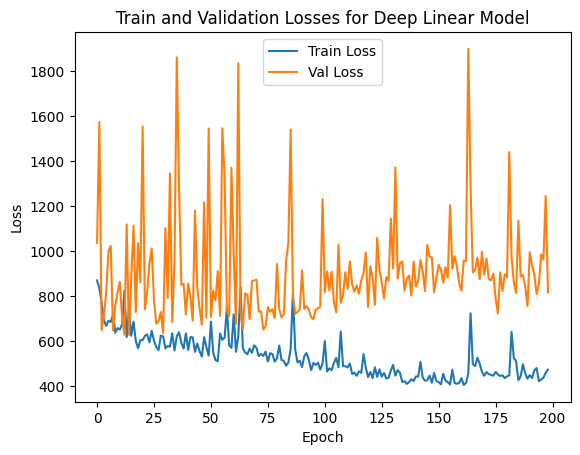

In [24]:
# Plot train and val losses
plt.plot(train_losses[1:], label='Train Loss')
plt.plot(val_losses[1:], label='Val Loss')
plt.title('Train and Validation Losses for Deep Linear Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
# Compute final metric values
print(f"Train MSE: {computeMSE(train_loader,model_linear)}")
print(f"Val MSE: {computeMSE(val_loader,model_linear)}")

Train MSE: 565.1728515625
Val MSE: 622.9404907226562


### 1D Convolutional Neural Network

We can also try a convolutional neural network. A temporal covnet can implement the representations of different time scales in the data simultaneously.

By applying multiple convolutional layers, the network can learn hierarchical representations of the data. After each convolutional layer, max pooling reduces the dimensionality of the data.

In [26]:
class ConvolutionalModel (nn.Module):
    def __init__(self, output_size):
        super(ConvolutionalModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding = 2) 
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride = 2) 
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding = 2) 
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 35, 128)
        self.fc2 = nn.Linear(128,output_size)

    def forward(self, x):
        x = x.unsqueeze(1) # add a channel dimension so that it is batch_size x C x L
        x = self.conv1(x) # input: 1 x seq_length, output: 32 x seq_length
        x = self.relu(x)
        x = self.pool(x) # input: seq_length x 32, output: seq_length/2 x 32
        x = self.conv2(x) # input: seq_length/2 x 32, output: seq_length/2 x 64
        x = self.relu(x)
        x = self.pool(x) # input: seq_length/2 x 64, output: seq_length/4 x 64
        x = self.flatten(x) # input: seq_length/4 x 64, output: (seq_length/4)*64
        x = self.fc1(x) # input: (seq_length/4)*64, output: 128
        x = self.relu(x)
        x = self.fc2(x) # input: 128, output: 1
        return x

In [27]:
#initiate the model
model_conv = ConvolutionalModel(output_size = 1)
model_conv = model_conv.to(device)
print(model_conv)

ConvolutionalModel(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2240, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


Epoch 0, Train MSE: 22976.8827, Val MSE: 1087.3069
Epoch 10, Train MSE: 607.9125, Val MSE: 579.8637
Epoch 20, Train MSE: 619.0930, Val MSE: 560.2350
Epoch 30, Train MSE: 585.6624, Val MSE: 623.8134
Epoch 40, Train MSE: 659.6152, Val MSE: 1406.1431
Epoch 50, Train MSE: 590.3958, Val MSE: 789.6783
Epoch 60, Train MSE: 657.3337, Val MSE: 743.1756
Epoch 70, Train MSE: 616.6191, Val MSE: 926.8488
Epoch 80, Train MSE: 486.2680, Val MSE: 818.2708
Epoch 90, Train MSE: 406.1732, Val MSE: 904.3509
Epoch 100, Train MSE: 426.4022, Val MSE: 981.0386
Epoch 110, Train MSE: 351.1614, Val MSE: 1051.2552
Epoch 120, Train MSE: 512.1195, Val MSE: 910.6966
Epoch 130, Train MSE: 304.6229, Val MSE: 944.7929
Epoch 140, Train MSE: 276.0814, Val MSE: 1053.9530
Epoch 150, Train MSE: 354.0531, Val MSE: 1159.3330
Epoch 160, Train MSE: 209.4406, Val MSE: 1336.0639
Epoch 170, Train MSE: 165.1084, Val MSE: 1343.2482
Epoch 180, Train MSE: 151.8504, Val MSE: 1416.4394
Epoch 190, Train MSE: 153.3501, Val MSE: 1312.3297


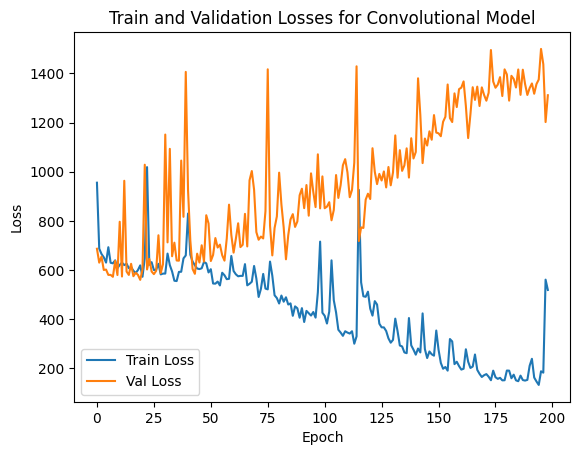

In [28]:
lossfunction = nn.MSELoss()
optimizer = torch.optim.Adam(model_conv.parameters(), lr=0.01)
Nepochs = 200
best_model_path = 'best_model_conv.pth' # set where the best validation performing model will be stored
train_losses, val_losses = train(model = model_conv, train_loader = train_loader, val_loader = val_loader,lossfunction = lossfunction, optimizer = optimizer, num_epochs = Nepochs, best_model_path=best_model_path)

# retrieve best performing model
model_conv.load_state_dict(torch.load(best_model_path))

# Plot train and val losses
plt.plot(train_losses[1:], label='Train Loss')
plt.plot(val_losses[1:], label='Val Loss')
plt.title('Train and Validation Losses for Convolutional Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can see that this model is able to learn much more from the training data! However, it is overfitting to the learning data. We could deal with this by using dropout, L2 regularization, or early stopping.

In [29]:
# Compute final metric values
print(f"Train MSE: {computeMSE(train_loader,model_conv)}")
print(f"Val MSE: {computeMSE(val_loader,model_conv)}")

Train MSE: 561.9673461914062
Val MSE: 555.794677734375


### LSTM Model

An LSTM model can be better than a simple deep model or 1D convolutional model for time series forecasting because it can capture long-term dependencies and patterns in sequential data by maintaining a memory of past information over multiple time steps

In [30]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size = 1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size) 

    def forward(self, x):
        x = x.unsqueeze(-1) # LSTM expects input of shape (batch_size, seq_length, num_features)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Get output from the last time step
        return out

In [31]:
model_LSTM = LSTMModel(input_size = 1, hidden_size= 64, num_layers=2) # 1 input feature, 64 hidden units, 2 LSTM layers
model_LSTM = model_LSTM.to(device)
print(model_LSTM)

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


Epoch 0, Train MSE: 7214.1663, Val MSE: 9979.2897
Epoch 10, Train MSE: 4150.0609, Val MSE: 7170.5066
Epoch 20, Train MSE: 869.9283, Val MSE: 1405.6711
Epoch 30, Train MSE: 733.1885, Val MSE: 981.8522
Epoch 40, Train MSE: 860.9439, Val MSE: 1024.3953
Epoch 50, Train MSE: 697.0656, Val MSE: 855.0320
Epoch 60, Train MSE: 675.5963, Val MSE: 886.2224
Epoch 70, Train MSE: 706.9397, Val MSE: 763.8202
Epoch 80, Train MSE: 746.8147, Val MSE: 972.4141
Epoch 90, Train MSE: 659.1465, Val MSE: 786.7458
Epoch 100, Train MSE: 680.0198, Val MSE: 863.8936
Epoch 110, Train MSE: 668.2495, Val MSE: 748.5881
Epoch 120, Train MSE: 674.5996, Val MSE: 686.3896
Epoch 130, Train MSE: 743.3256, Val MSE: 916.7118
Epoch 140, Train MSE: 702.7810, Val MSE: 785.2586
Epoch 150, Train MSE: 709.4013, Val MSE: 733.6929
Epoch 160, Train MSE: 890.9784, Val MSE: 1077.8857
Epoch 170, Train MSE: 849.7579, Val MSE: 1439.0021
Epoch 180, Train MSE: 718.5387, Val MSE: 985.2984
Epoch 190, Train MSE: 721.3098, Val MSE: 1081.3547


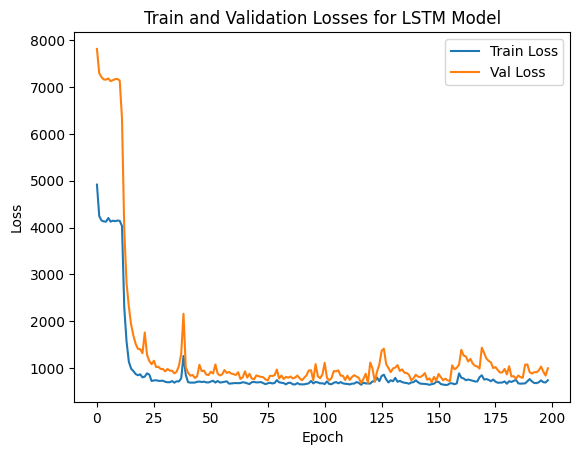

In [32]:
lossfunction = nn.MSELoss()
optimizer = torch.optim.Adam(model_LSTM.parameters(), lr=0.01)
Nepochs = 200
best_model_path = 'best_model_LSTM.pth' # set where the best validation performing model will be stored
train_losses, val_losses = train(model = model_LSTM, train_loader = train_loader, val_loader = val_loader,lossfunction = lossfunction, optimizer = optimizer, num_epochs = Nepochs, best_model_path=best_model_path)

# retrieve best performing model
model_LSTM.load_state_dict(torch.load(best_model_path))

# Plot train and val losses
plt.plot(train_losses[1:], label='Train Loss')
plt.plot(val_losses[1:], label='Val Loss')
plt.title('Train and Validation Losses for LSTM Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
# Compute final metric values
print(f"Train MSE: {computeMSE(train_loader,model_LSTM)}")
print(f"Val MSE: {computeMSE(val_loader,model_LSTM)}")

Train MSE: 644.3619995117188
Val MSE: 680.4644775390625


### GRU Model

GRUs are a simplified version of LSTMs and are more efficient to train. They have fewer parameters and are therefore faster to train. We can try a GRU model to see if it can outperform the LSTM model.

In [34]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size = 1):
        super(GRUModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size) 

    def forward(self, x):
        x = x.unsqueeze(-1) # GRU expects input of shape (batch_size, seq_length, num_features)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, h0)
        out = self.fc(out[:, -1, :])  # Get output from the last time step
        return out

we can add more hidden layers to the GRU model as it is more simple than the LSTM

In [35]:
model_GRU = GRUModel(input_size = 1, hidden_size= 128, num_layers=2) # 1 input feature, 128 hidden units, 2 GRU layers
model_GRU = model_GRU.to(device)
print(model_GRU)

GRUModel(
  (lstm): GRU(1, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


Epoch 0, Train MSE: 5866.6413, Val MSE: 7626.1580
Epoch 10, Train MSE: 886.7917, Val MSE: 1353.7348
Epoch 20, Train MSE: 803.1707, Val MSE: 1199.9120
Epoch 30, Train MSE: 853.0432, Val MSE: 1358.2310
Epoch 40, Train MSE: 772.0501, Val MSE: 914.4211
Epoch 50, Train MSE: 855.7475, Val MSE: 1590.0187
Epoch 60, Train MSE: 822.9546, Val MSE: 1155.3703
Epoch 70, Train MSE: 843.2147, Val MSE: 974.3182
Epoch 80, Train MSE: 891.9008, Val MSE: 1642.5663
Epoch 90, Train MSE: 891.6290, Val MSE: 1245.3729
Epoch 100, Train MSE: 835.8510, Val MSE: 1089.7334
Epoch 110, Train MSE: 824.0822, Val MSE: 1147.0523
Epoch 120, Train MSE: 805.7748, Val MSE: 1048.5705
Epoch 130, Train MSE: 904.6913, Val MSE: 1512.5021
Epoch 140, Train MSE: 863.2514, Val MSE: 1348.0579
Epoch 150, Train MSE: 876.2629, Val MSE: 1116.5741
Epoch 160, Train MSE: 971.9600, Val MSE: 1678.8280
Epoch 170, Train MSE: 913.1772, Val MSE: 1217.2493
Epoch 180, Train MSE: 931.4523, Val MSE: 1619.2401
Epoch 190, Train MSE: 1150.8501, Val MSE: 2

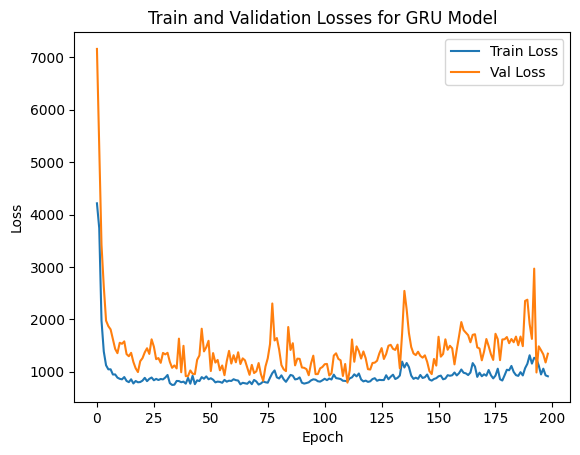

In [36]:
lossfunction = nn.MSELoss()
optimizer = torch.optim.Adam(model_GRU.parameters(), lr=0.01)
Nepochs = 200
best_model_path = 'best_model_GRU.pth' # set where the best validation performing model will be stored
train_losses, val_losses = train(model = model_GRU, train_loader = train_loader, val_loader = val_loader,lossfunction = lossfunction, optimizer = optimizer, num_epochs = Nepochs, best_model_path=best_model_path)

# retrieve best performing model
model_GRU.load_state_dict(torch.load(best_model_path))

# Plot train and val losses
plt.plot(train_losses[1:], label='Train Loss')
plt.plot(val_losses[1:], label='Val Loss')
plt.title('Train and Validation Losses for GRU Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
# Compute final metric values
print(f"Train MSE: {computeMSE(train_loader,model_GRU)}")
print(f"Val MSE: {computeMSE(val_loader,model_GRU)}")

Train MSE: 772.166015625
Val MSE: 786.7488403320312


## Comparing Models

Lets compare all the models we have trained so far on data they have never seen before, that is the test data!

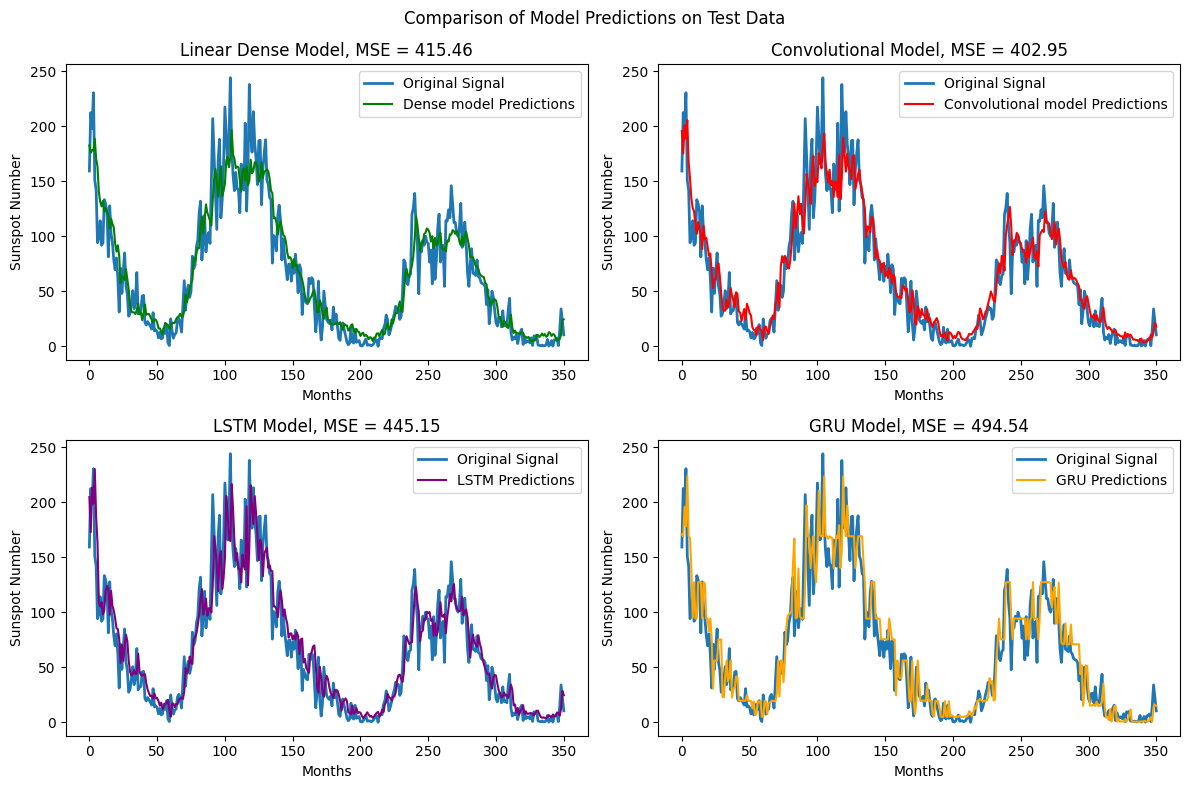

In [38]:
# Make predictions on the testing set for visualization
test_predictions_linear, true_targets = generateSequence(model=model_linear, loader=test_loader)
test_predictions_conv, _ = generateSequence(model=model_conv, loader=test_loader)
test_predictions_LSTM, _ = generateSequence(model=model_LSTM, loader=test_loader)
test_predictions_GRU, _ = generateSequence(model=model_GRU, loader=test_loader) 

# Plot the original signal and testing predictions
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Comparison of Model Predictions on Test Data')
# Linear Dense Model
axs[0, 0].plot(true_targets, label='Original Signal', linewidth=2)
axs[0, 0].plot(test_predictions_linear, label='Dense model Predictions', color = 'green')
axs[0, 0].set_xlabel('Months')
axs[0, 0].set_ylabel('Sunspot Number')
axs[0, 0].set_title(f"Linear Dense Model, MSE = {computeMSE(test_loader,model_linear):.2f}")
axs[0, 0].legend()

# Convolutional Model
axs[0, 1].plot(true_targets, label='Original Signal', linewidth=2)
axs[0, 1].plot(test_predictions_conv, label='Convolutional model Predictions', color='red')
axs[0, 1].set_xlabel('Months')
axs[0, 1].set_ylabel('Sunspot Number')
axs[0, 1].set_title(f"Convolutional Model, MSE = {computeMSE(test_loader,model_conv):.2f}")
axs[0, 1].legend()

# LSTM Model
axs[1, 0].plot(true_targets, label='Original Signal', linewidth=2)
axs[1, 0].plot(test_predictions_LSTM, label='LSTM Predictions', color = 'purple')
axs[1, 0].set_xlabel('Months')
axs[1, 0].set_ylabel('Sunspot Number')
axs[1, 0].set_title(f"LSTM Model, MSE = {computeMSE(test_loader,model_LSTM):.2f}")
axs[1, 0].legend()

# GRU Model
axs[1, 1].plot(true_targets, label='Original Signal', linewidth=2)
axs[1, 1].plot(test_predictions_GRU, label='GRU Predictions', color = 'orange')
axs[1, 1].set_xlabel('Months')
axs[1, 1].set_ylabel('Sunspot Number')
axs[1, 1].set_title(f"GRU Model, MSE = {computeMSE(test_loader,model_GRU):.2f}")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

Seems like the convolutional layer is the best performing model! In time series forecasting, CNNs can effectively capture temporal patterns and dependencies across different time steps, especially when the data exhibits local patterns or spatial correlations, as is the case with sunspot data.

As next steps, we could try and changing hyperparameters for the best or all the models, or try a different architecture altogether.

## Conclusion: Final Model

To finalize, lets try to get the best model possible, by trying to fine tune the previous best-performing model (Convolutional):

We can add more layers so it can learn even more patterns, and we can use regularization techniques, such as dropout, to prevent overfitting to the training data. We could also train it for more epochs, and use a lower learning rate

In [39]:
class ConvolutionalModel2(nn.Module):
    def __init__(self, output_size):
        super(ConvolutionalModel2, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2) # Additional convolutional layer
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool1d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)  # Add dropout layer with dropout rate of 0.5 -> this will aid in preventing overfitting
        self.fc1 = nn.Linear(128 * 17, 256)
        self.fc2 = nn.Linear(256, 128) # add extra linear layer
        self.fc3 = nn.Linear(128, output_size) 

    def forward(self, x):
        x = x.unsqueeze(1) # Add a channel dimension so that it is batch_size x C x L
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)  # Add the third convolutional layer
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.dropout(x)  # Apply dropout
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)  # Apply dropout

        x = self.relu(x)
        x = self.fc3(x)
        return x

ConvolutionalModel2(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu): ReLU()
  (pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)
Epoch 0, Train MSE: 4587.9970, Val MSE: 1905.3572
Epoch 10, Train MSE: 956.2700, Val MSE: 629.5742
Epoch 20, Train MSE: 809.4829, Val MSE: 689.1494
Epoch 30, Train MSE: 816.6931, Val MSE: 570.2681
Epoch 40, Train MSE: 809.3709, Val MSE: 699.2006
Epoch 50, Train MSE: 794.2658, Val MSE: 767.9509
Epoch 60, Train MSE: 745.1171, Val MSE: 664.5822
Epoch 70, Train MSE: 725.8230, Val MSE: 696.2253
Epoch 80, Train

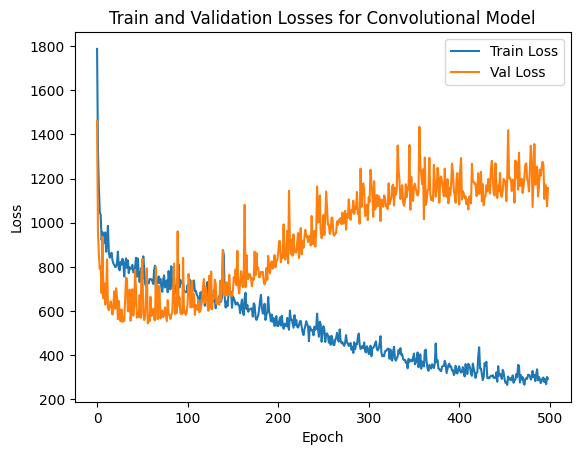

In [40]:
#initiate the model
model_final = ConvolutionalModel2(output_size = 1)
model_final = model_final.to(device)
print(model_final)
lossfunction = nn.MSELoss()
optimizer = torch.optim.Adam(model_final.parameters(), lr=0.0001)
Nepochs = 500
best_model_path = 'best_model_final.pth' # set where the best validation performing model will be stored
train_losses, val_losses = train(model = model_final, train_loader = train_loader, val_loader = val_loader,lossfunction = lossfunction, optimizer = optimizer, num_epochs = Nepochs, best_model_path=best_model_path)

# retrieve best performing model
model_final.load_state_dict(torch.load(best_model_path))

# Plot train and val losses
plt.plot(train_losses[1:], label='Train Loss')
plt.plot(val_losses[1:], label='Val Loss')
plt.title('Train and Validation Losses for Convolutional Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can see clearly that at some point, the model starts overfitting to the training data. We restore the model to the best validation performing one.

In [41]:
# Compute final metric values
print(f"Train MSE: {computeMSE(train_loader,model_final)}")
print(f"Val MSE: {computeMSE(val_loader,model_final)}")

Train MSE: 532.2052612304688
Val MSE: 539.4644165039062


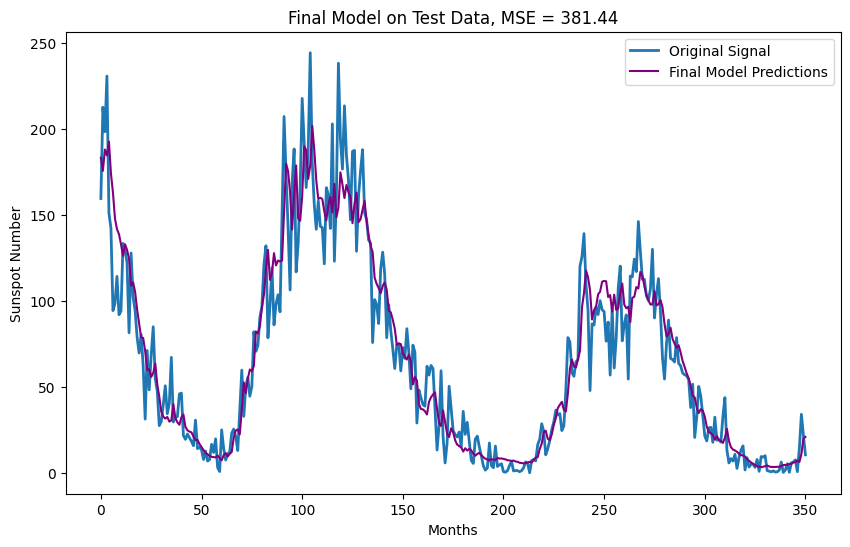

In [42]:
test_predictions_final, true_targets = generateSequence(model=model_final, loader=test_loader)
plt.figure(figsize=(10, 6))

plt.plot(true_targets, label='Original Signal', linewidth=2)
plt.plot(test_predictions_final, label='Final Model Predictions', color='purple')
plt.title(f"Final Model on Test Data, MSE = {computeMSE(test_loader,model_final):.2f}")
plt.xlabel('Months')
plt.ylabel('Sunspot Number')
plt.legend()
plt.show()

And predicting on all the data:

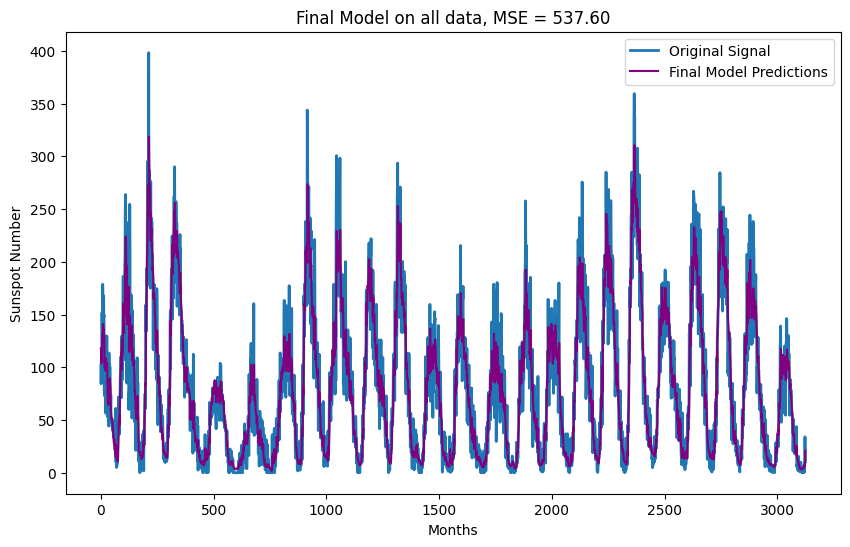

In [43]:
test_predictions_final, true_targets = generateSequence(model=model_final, loader=all_loader)

plt.figure(figsize=(10, 6))
plt.plot(true_targets, label='Original Signal', linewidth=2)
plt.plot(test_predictions_final, label='Final Model Predictions', color='purple')
plt.title(f"Final Model on all data, MSE = {computeMSE(all_loader,model_final):.2f}")
plt.xlabel('Months')
plt.ylabel('Sunspot Number')
plt.legend()
plt.show()